In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils import shuffle
from imblearn import under_sampling
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import SelectKBest, SelectFromModel, mutual_info_classif, f_classif, VarianceThreshold
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
plt.style.use("default")

In [7]:
df = pd.read_csv("asteroid.csv", low_memory=False)

In [8]:
df.head()

,full_name,neo,pha,H,G,M1,M2,K1,K2,PC,...,tp,per,per.y,class,condition_code,A1,A2,A3,DT,moid
0,433 Eros (A898 PA),Y,N,10.43,0.46,NaN,NaN,NaN,NaN,NaN,...,2459802.57,643.0,1.76,AMO,0.0,NaN,NaN,NaN,NaN,0.1490
1,719 Albert (A911 TB),Y,N,15.51,NaN,NaN,NaN,NaN,NaN,NaN,...,2459956.01,1560.0,4.28,AMO,0.0,NaN,NaN,NaN,NaN,0.2030
2,887 Alinda (A918 AA),Y,N,13.87,-0.12,NaN,NaN,NaN,NaN,NaN,...,2459258.73,1420.0,3.89,AMO,0.0,NaN,NaN,NaN,NaN,0.0815
3,1036 Ganymed (A924 UB),Y,N,9.25,0.30,NaN,NaN,NaN,NaN,NaN,...,2458979.34,1590.0,4.35,AMO,0.0,NaN,NaN,NaN,NaN,0.3450
4,1221 Amor (1932 EA1),Y,N,17.40,NaN,NaN,NaN,NaN,NaN,NaN,...,2459867.34,971.0,2.66,AMO,0.0,NaN,NaN,NaN,NaN,0.1060


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28198 entries, 0 to 28197
Data columns (total 42 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   full_name       28198 non-null  object 
 1   neo             28198 non-null  object 
 2   pha             28166 non-null  object 
 3   H               28195 non-null  float64
 4   G               13 non-null     float64
 5   M1              0 non-null      float64
 6   M2              0 non-null      float64
 7   K1              0 non-null      float64
 8   K2              0 non-null      float64
 9   PC              0 non-null      float64
 10  diameter        1248 non-null   float64
 11  extent          9 non-null      object 
 12  albedo          1203 non-null   float64
 13  rot_per         1882 non-null   float64
 14  GM              4 non-null      float64
 15  BV              38 non-null     float64
 16  UB              38 non-null     float64
 17  IR              1 non-null     

# Cleaning

## 1. Optimizing data types

In [10]:
def optimize_dtypes(df):
    ints = df.select_dtypes(include=['int64', 'int32']).columns.tolist()
    floats = df.select_dtypes(include=['float64', 'float32']).columns.tolist()
    df[ints] = df[ints].apply(pd.to_numeric, downcast='integer')
    df[floats] = df[floats].apply(pd.to_numeric, downcast='float')
    
    return df

In [11]:
df = optimize_dtypes(df)

## 2. Dropping Null Values

In [12]:
# Dropping the rows for which the class attribute is NULL
df = df[np.logical_not(df.pha.isnull())].reset_index(drop=True)

# Dropping the columns for which more than 50% of the values are NULL
df = df.drop(columns=df.columns[df.isnull().sum()/len(df) > 0.5].tolist())

# Dropping the rows with NULL values in the features
df = df.dropna().reset_index(drop=True)

## 3. Dropping unwanted columns

In [13]:
# Dropping columns with only one unique value
df = df.drop(columns=df.columns[np.where(np.array([df[col].unique().shape[0] for 
                                                   col in df.columns]) == 1)[0]].to_list())

## 4. Removing redundant columns

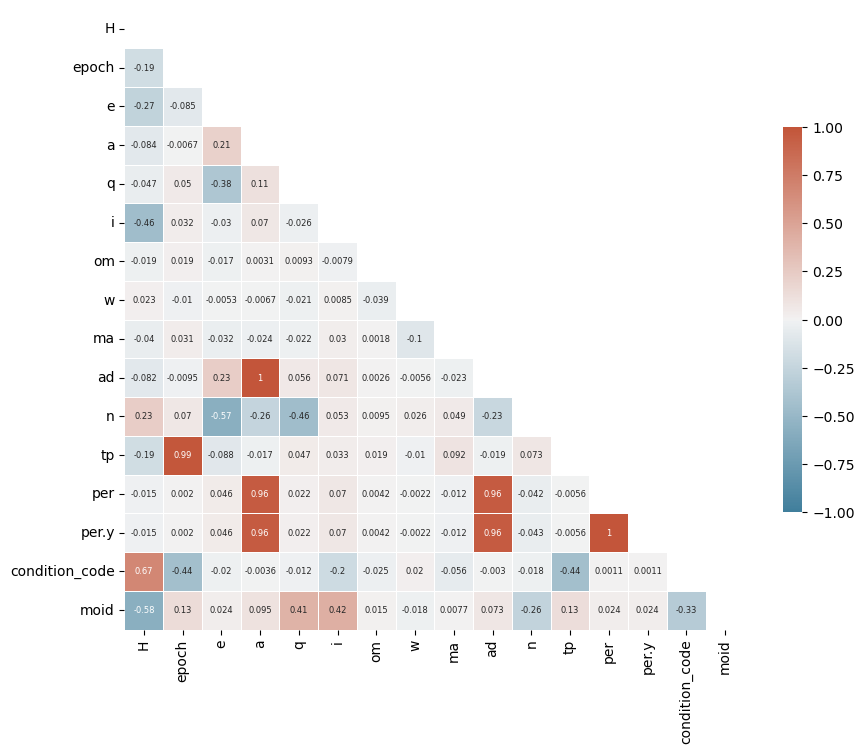

In [14]:
mask = np.triu(np.ones_like(df.corr().to_numpy()))

fig, ax = plt.subplots(1, 1, figsize=(10,10), dpi=100)
sns.heatmap(df.corr(), 
            mask=mask, 
            cmap=sns.diverging_palette(230, 20, as_cmap=True), 
            vmax=1,
            vmin=-1,
            center=0,
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5}, 
            annot=df.corr(), 
            annot_kws={'size':6}, 
            ax=ax);

In [15]:
df = df.drop(columns=["per", "epoch", "ad"])

In [17]:
df.shape

(28163, 16)

# EDA

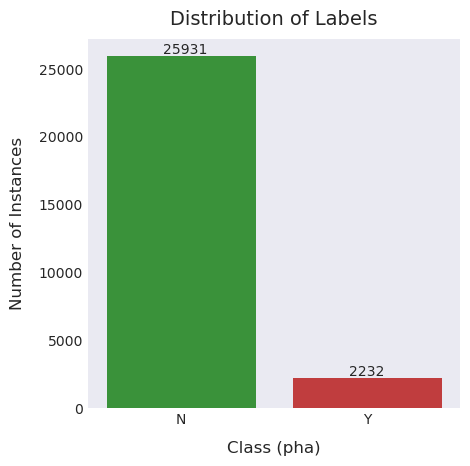

In [16]:
label_counts = pd.DataFrame(df.pha.value_counts()).reset_index().rename(columns={'index':'Class','pha':'Count'})
cols = ['tab:green', 'tab:red']

with plt.style.context('seaborn-dark'):
    fig, ax = plt.subplots(1, 1, figsize=(4.8,4.8), dpi=100)
    barplot = sns.barplot(data = label_counts, x='Class', y='Count',
                          palette=np.array(cols)[[0,1]], ax=ax)
    ax.set_title('Distribution of Labels', fontsize=14, pad=10)
    ax.set_xlabel('Class (pha)', fontsize=12, labelpad=10)
    ax.set_ylabel('Number of Instances', fontsize=12, labelpad=10)

    for bar in barplot.patches:
        width = bar.get_width()
        height = bar.get_height()
        ax.text(x=bar.get_x()+width/2-0.1, y=height+150, s=int(height))
        

# Preprocessing

## 1. Converting categorical features to dummy variables

In [10]:
df = pd.get_dummies(df, columns=['class'])

## 2. Separating into features and labels

In [11]:
X = df.drop(columns=['full_name', 'pha'])
Y = (df['pha'] == 'Y')

## 3. Stratified sampling into train and test sets

In [12]:
x_train, x_test, y_train, y_test = train_test_split(X.to_numpy(), 
                                                    Y.to_numpy().astype(np.uint8), 
                                                    test_size=0.34, 
                                                    stratify=Y)

## 4. Standard scaling

In [13]:
s = StandardScaler()
s.fit(x_train);
x_train = s.transform(x_train)
x_test = s.transform(x_test)

## 5. Undersampling of the training set

In [14]:
undersample = under_sampling.NearMiss(version=3, n_neighbors_ver3=5)
x_train_undersampled, y_train_undersampled = undersample.fit_resample(x_train, y_train)

# Shuffling the undersampled set
x_train_undersampled, y_train_undersampled = shuffle(x_train_undersampled, y_train_undersampled)

# Feature Selection

In [15]:
class feature_selector():
    
    def __init__(self, x_train, x_test, y_train, plot_imp=False):
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.plot_imp = plot_imp
    
    def print_selected_columns(self, indices):
        print("Selected attributes:")
        for i in indices:
            print("\t", X.columns.values[i])
        
    def plot_importances(self, importances):
        fig, ax = plt.subplots(1, 1, figsize=(10.8,4.8), dpi=100)
        ax.bar(X.columns.to_list(),height=importances)
        ax.set_xticks(ticks=np.arange(20), labels=X.columns.to_list(), rotation=90);
        
    def extra_trees(self):
        clf = ExtraTreesClassifier()
        clf.fit(self.x_train, self.y_train);
        heights = clf.feature_importances_
        
        indices = np.where(heights>0.075)[0]
        self.print_selected_columns(indices)
        
        x_train_selected = self.x_train[:, indices]
        x_test_selected = self.x_test[:, indices]
        
        if self.plot_imp:
            self.plot_importances(heights)
        
        return x_train_selected, x_test_selected
    
    def info_gain(self):
        heights = mutual_info_classif(self.x_train, self.y_train)
        
        indices = np.where(heights>0.025)[0]
        self.print_selected_columns(indices)
        
        x_train_selected = self.x_train[:, indices]
        x_test_selected = self.x_test[:, indices]
        
        if self.plot_imp:
            self.plot_importances(heights)
            
        return x_train_selected, x_test_selected
    
    def anova(self):
        fs = SelectKBest(f_classif, k='all')
        fs.fit(self.x_train, self.y_train)
        heights = fs.scores_
        
        indices = sorted(np.argsort(heights)[-3:])
        self.print_selected_columns(indices)
        
        x_train_selected = self.x_train[:, indices]
        x_test_selected = self.x_test[:, indices]
        
        if self.plot_imp:
            self.plot_importances(heights)
            
        return x_train_selected, x_test_selected
    
    def forward_feature_selection(self):
        
        lr = LogisticRegression()
        ffs = SequentialFeatureSelector(lr, k_features='best', forward=True, n_jobs=-1)
        ffs.fit(self.x_train, self.y_train);
        
        indices = list(map(int, ffs.k_feature_names_))
        self.print_selected_columns(indices)
        
        x_train_selected = self.x_train[:, indices]
        x_test_selected = self.x_test[:, indices]
        
        return x_train_selected, x_test_selected
    
    def lasso(self):
        
        lr = LogisticRegression(penalty='l1', solver='liblinear')
        lr.fit(self.x_train, self.y_train);
        lasso_selector = SelectFromModel(lr, prefit=True)
        
        x_train_selected = lasso_selector.transform(self.x_train)
        
        indices = np.array([[(self.x_train[:,i] == x_train_selected[:,j]).all() for j in range(x_train_selected.shape[1])] 
                            for i in range(self.x_train.shape[1])]).any(axis=1)
        indices = np.where(indices)[0]
        self.print_selected_columns(indices)
        
        x_test_selected = self.x_test[:, indices]
        
        return x_train_selected, x_test_selected

In [16]:
feat = feature_selector(x_train_undersampled, x_test, y_train_undersampled)

## 1. Extra Trees Classifier

In [17]:
x_train_reduced_extra_trees, x_test_reduced_extra_trees = feat.extra_trees()

Selected attributes:
	 H
	 condition_code
	 moid


## 2. Mutual Info Gain

In [18]:
x_train_reduced_info_gain, x_test_reduced_info_gain = feat.info_gain()

Selected attributes:
	 H
	 q
	 tp
	 condition_code
	 moid
	 class_APO


## 3. ANOVA f-test

In [19]:
x_train_reduced_anova, x_test_reduced_anova = feat.anova()

Selected attributes:
	 H
	 condition_code
	 moid


## 4. Forward Feature Selection

In [20]:
x_train_reduced_ffs, x_test_reduced_ffs = feat.forward_feature_selection()

Selected attributes:
	 H
	 e
	 q
	 i
	 w
	 moid
	 class_ATE


## 5. Variance Threshold

In [21]:
x_train_reduced_lasso, x_test_reduced_lasso = feat.lasso()

Selected attributes:
	 H
	 e
	 a
	 q
	 i
	 w
	 ma
	 n
	 tp
	 condition_code
	 moid
	 class_AMO
	 class_APO
	 class_IEO


# Validation Metrics

In [22]:
def metrics(y_true, y_pred):
    
    acc = 100*np.mean(y_true==y_pred)
    print("Test Accuracy: {:.4f}%".format(acc))
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    recall = tp/(tp+fn)
    precision = tp/(tp+fp)
    f1_score = 2*precision*recall/(precision+recall)
    mcc = ((tp*tn) - (fp*fn))/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    auc_score = roc_auc_score(y_true, y_pred)
    
    print("Classification Report:\n",
      classification_report(y_true, y_pred))
    
    conf_mat = confusion_matrix(y_true, y_pred)
    
    fig, ax = plt.subplots(1, 2, figsize=(7.2,3.6), dpi=100)
    sns.heatmap(conf_mat, 
                ax=ax[0], 
                annot=True, 
                linecolor='white', 
                linewidth=1, 
                square=True, 
                fmt='d', 
                cmap='vlag_r', 
                cbar=False)
    
    ax[0].set_xlabel("Predicted Label", fontsize=12, labelpad=15)
    ax[0].set_ylabel("True Label", fontsize=12, labelpad=15)
    ax[0].set_title("Confusion Matrix", fontsize=14, pad=15)
    
    y1 = OneHotEncoder().fit_transform(y_test.reshape(-1,1)).toarray()
    y2 = OneHotEncoder().fit_transform(y_pred.reshape(-1,1)).toarray()

    for (i, class_name) in enumerate([0,1]):
        fpr, tpr, _ = roc_curve(y1[:,i], y2[:,i])
        
        ax[1].plot(fpr, tpr, label="{} - AUC = {:.4f}".format(class_name, auc(fpr, tpr)))
        ax[1].plot(fpr, fpr, linestyle="--", color='blue')
        ax[1].set_xlabel('False Positive Rate', fontsize=12, labelpad=10)
        ax[1].set_ylabel('True Positive Rate', fontsize=12, labelpad=10)
        ax[1].grid(linestyle=":", alpha=0.25)
        ax[1].legend(loc='best')
        
    plt.subplots_adjust(wspace=0.3);
    
    return [acc, recall, precision, f1_score, mcc, auc_score]
    

# Classifiers

In [23]:
metrics_list = []

## Naive Bayes

In [24]:
clf = GaussianNB()

### 1. Extra Trees

Test Accuracy: 97.1074%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      8817
           1       0.76      0.92      0.83       759

    accuracy                           0.97      9576
   macro avg       0.88      0.95      0.91      9576
weighted avg       0.97      0.97      0.97      9576



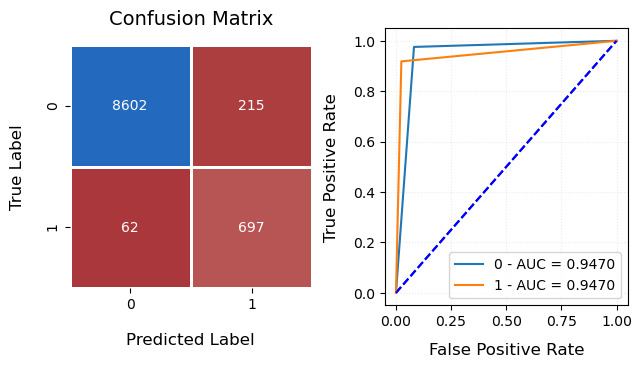

In [25]:
clf.fit(x_train_reduced_extra_trees, y_train_undersampled);
y_pred = clf.predict(x_test_reduced_extra_trees)

metrics_list.append(metrics(y_test, y_pred))

### 2. Mutual Info Gain

Test Accuracy: 95.6349%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.98      8817
           1       0.66      0.92      0.77       759

    accuracy                           0.96      9576
   macro avg       0.83      0.94      0.87      9576
weighted avg       0.97      0.96      0.96      9576



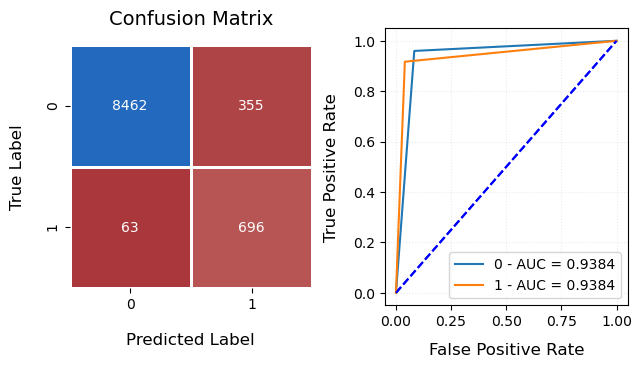

In [26]:
clf.fit(x_train_reduced_info_gain, y_train_undersampled);
y_pred = clf.predict(x_test_reduced_info_gain)

metrics_list.append(metrics(y_test, y_pred))

### 3. ANOVA f-test

Test Accuracy: 97.1074%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      8817
           1       0.76      0.92      0.83       759

    accuracy                           0.97      9576
   macro avg       0.88      0.95      0.91      9576
weighted avg       0.97      0.97      0.97      9576



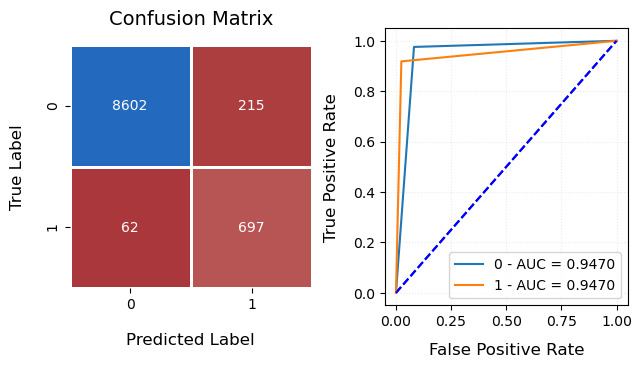

In [27]:
clf.fit(x_train_reduced_anova, y_train_undersampled);
y_pred = clf.predict(x_test_reduced_anova)

metrics_list.append(metrics(y_test, y_pred))

### 4. Forward Feature Selection

Test Accuracy: 93.2853%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.93      0.96      8817
           1       0.55      0.91      0.68       759

    accuracy                           0.93      9576
   macro avg       0.77      0.92      0.82      9576
weighted avg       0.96      0.93      0.94      9576



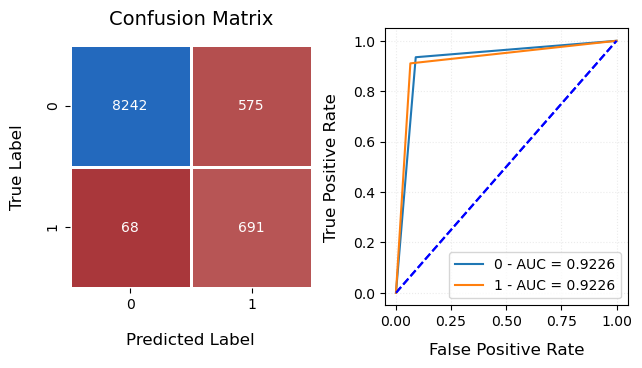

In [28]:
clf.fit(x_train_reduced_ffs, y_train_undersampled);
y_pred = clf.predict(x_test_reduced_ffs)

metrics_list.append(metrics(y_test, y_pred))

### 5. Lasso Regression

Test Accuracy: 92.6378%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.93      0.96      8817
           1       0.52      0.86      0.65       759

    accuracy                           0.93      9576
   macro avg       0.75      0.90      0.80      9576
weighted avg       0.95      0.93      0.93      9576



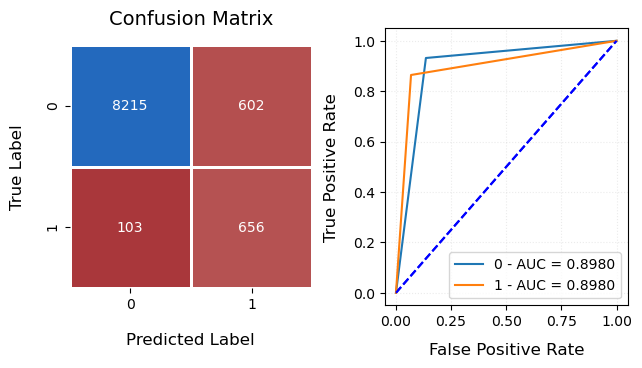

In [29]:
clf.fit(x_train_reduced_lasso, y_train_undersampled);
y_pred = clf.predict(x_test_reduced_lasso)

metrics_list.append(metrics(y_test, y_pred))

## Logistic Regression

In [30]:
clf = LogisticRegression()

### 1. Extra Trees

Test Accuracy: 95.8647%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.98      8817
           1       0.68      0.89      0.77       759

    accuracy                           0.96      9576
   macro avg       0.84      0.93      0.88      9576
weighted avg       0.97      0.96      0.96      9576



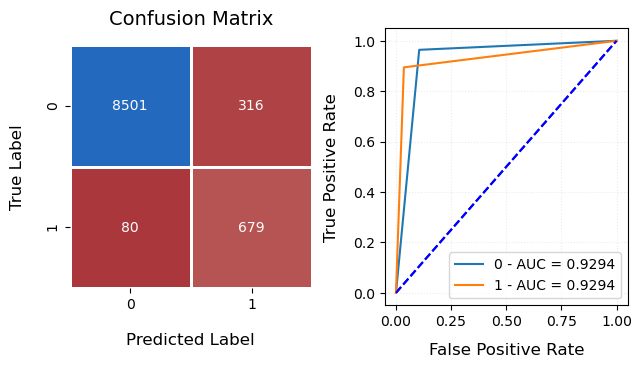

In [31]:
clf.fit(x_train_reduced_extra_trees, y_train_undersampled);
y_pred = clf.predict(x_test_reduced_extra_trees)

metrics_list.append(metrics(y_test, y_pred))

### 2. Mutual Info Gain

Test Accuracy: 95.3321%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.97      8817
           1       0.65      0.89      0.75       759

    accuracy                           0.95      9576
   macro avg       0.82      0.92      0.86      9576
weighted avg       0.96      0.95      0.96      9576



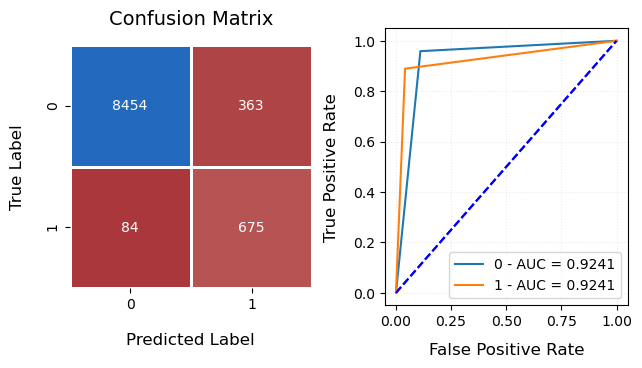

In [32]:
clf.fit(x_train_reduced_info_gain, y_train_undersampled);
y_pred = clf.predict(x_test_reduced_info_gain)

metrics_list.append(metrics(y_test, y_pred))

### 3. ANOVA f-test

Test Accuracy: 95.8647%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.98      8817
           1       0.68      0.89      0.77       759

    accuracy                           0.96      9576
   macro avg       0.84      0.93      0.88      9576
weighted avg       0.97      0.96      0.96      9576



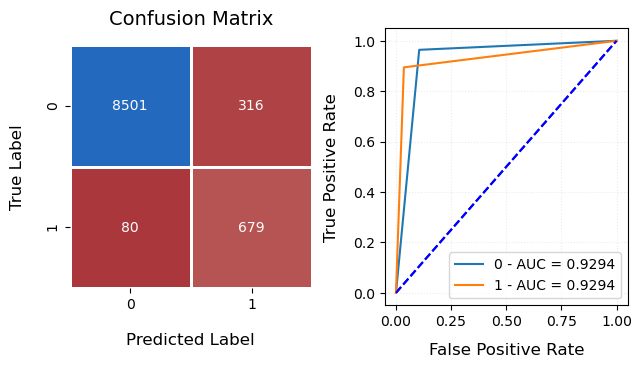

In [33]:
clf.fit(x_train_reduced_anova, y_train_undersampled);
y_pred = clf.predict(x_test_reduced_anova)

metrics_list.append(metrics(y_test, y_pred))

### 4. Forward Feature Selection

Test Accuracy: 95.2590%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.97      8817
           1       0.64      0.90      0.75       759

    accuracy                           0.95      9576
   macro avg       0.82      0.93      0.86      9576
weighted avg       0.96      0.95      0.96      9576



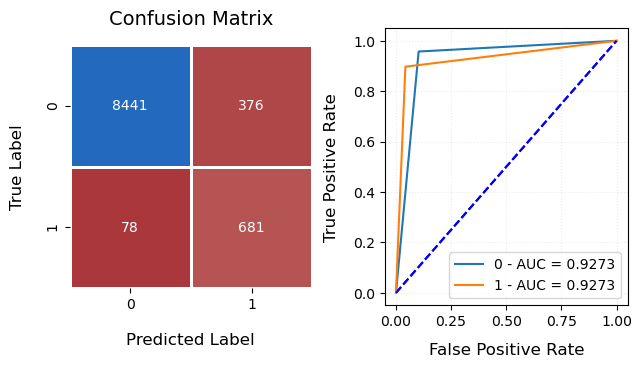

In [34]:
clf.fit(x_train_reduced_ffs, y_train_undersampled);
y_pred = clf.predict(x_test_reduced_ffs)

metrics_list.append(metrics(y_test, y_pred))

### 5. Lasso Regression

Test Accuracy: 95.1546%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.97      8817
           1       0.64      0.89      0.74       759

    accuracy                           0.95      9576
   macro avg       0.81      0.92      0.86      9576
weighted avg       0.96      0.95      0.96      9576



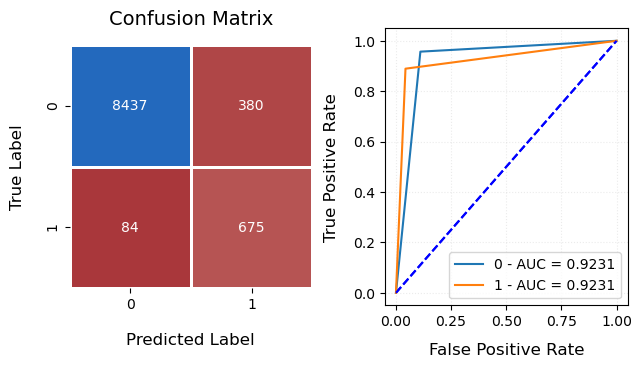

In [35]:
clf.fit(x_train_reduced_lasso, y_train_undersampled);
y_pred = clf.predict(x_test_reduced_lasso)

metrics_list.append(metrics(y_test, y_pred))

## KNN

In [36]:
clf = KNeighborsClassifier()

### 1. Extra Trees

Test Accuracy: 98.6007%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      8817
           1       0.86      0.99      0.92       759

    accuracy                           0.99      9576
   macro avg       0.93      0.99      0.96      9576
weighted avg       0.99      0.99      0.99      9576



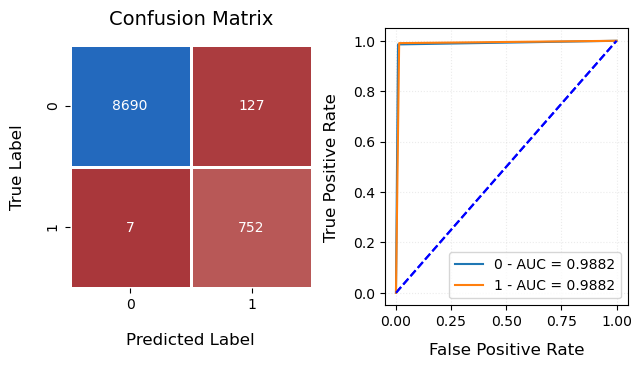

In [37]:
clf.fit(x_train_reduced_extra_trees, y_train_undersampled);
y_pred = clf.predict(x_test_reduced_extra_trees)

metrics_list.append(metrics(y_test, y_pred))

### 2. Mutual Info Gain

Test Accuracy: 96.7523%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98      8817
           1       0.73      0.95      0.82       759

    accuracy                           0.97      9576
   macro avg       0.86      0.96      0.90      9576
weighted avg       0.97      0.97      0.97      9576



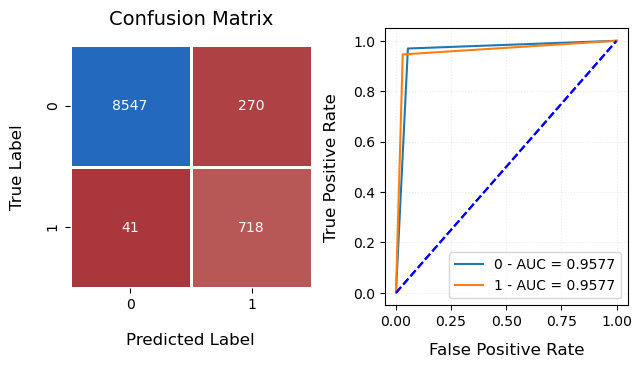

In [38]:
clf.fit(x_train_reduced_info_gain, y_train_undersampled);
y_pred = clf.predict(x_test_reduced_info_gain)

metrics_list.append(metrics(y_test, y_pred))

### 3. ANOVA f-test

Test Accuracy: 98.6007%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      8817
           1       0.86      0.99      0.92       759

    accuracy                           0.99      9576
   macro avg       0.93      0.99      0.96      9576
weighted avg       0.99      0.99      0.99      9576



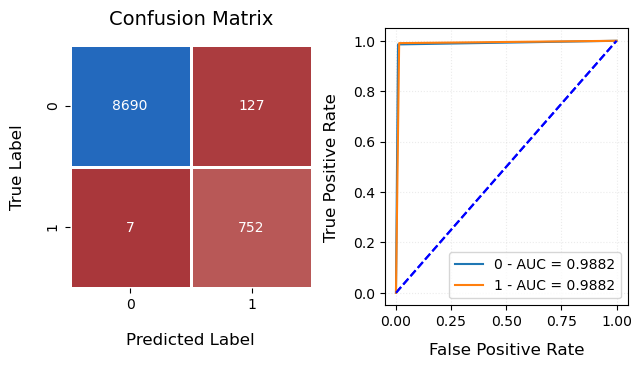

In [39]:
clf.fit(x_train_reduced_anova, y_train_undersampled);
y_pred = clf.predict(x_test_reduced_anova)

metrics_list.append(metrics(y_test, y_pred))

### 4. Forward Feature Selection

Test Accuracy: 94.1938%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.94      0.97      8817
           1       0.59      0.91      0.71       759

    accuracy                           0.94      9576
   macro avg       0.79      0.93      0.84      9576
weighted avg       0.96      0.94      0.95      9576



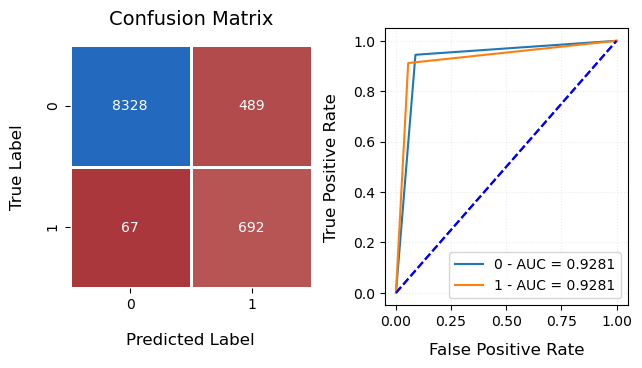

In [40]:
clf.fit(x_train_reduced_ffs, y_train_undersampled);
y_pred = clf.predict(x_test_reduced_ffs)

metrics_list.append(metrics(y_test, y_pred))

### 5. Lasso Regression

Test Accuracy: 91.9799%
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.93      0.96      8817
           1       0.50      0.83      0.62       759

    accuracy                           0.92      9576
   macro avg       0.74      0.88      0.79      9576
weighted avg       0.95      0.92      0.93      9576



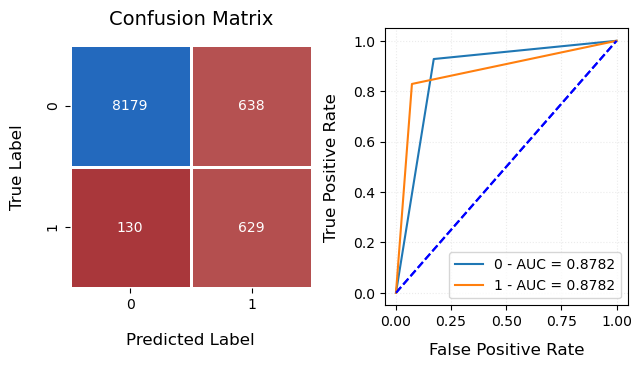

In [41]:
clf.fit(x_train_reduced_lasso, y_train_undersampled);
y_pred = clf.predict(x_test_reduced_lasso)

metrics_list.append(metrics(y_test, y_pred))

## Random Forest

In [42]:
clf = RandomForestClassifier()

### 1. Extra Trees

Test Accuracy: 99.7494%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8817
           1       0.98      0.99      0.98       759

    accuracy                           1.00      9576
   macro avg       0.99      0.99      0.99      9576
weighted avg       1.00      1.00      1.00      9576



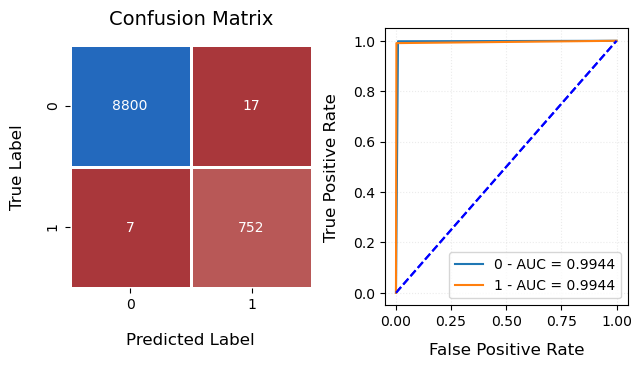

In [43]:
clf.fit(x_train_reduced_extra_trees, y_train_undersampled);
y_pred = clf.predict(x_test_reduced_extra_trees)

metrics_list.append(metrics(y_test, y_pred))

### 2. Mutual Info Gain

Test Accuracy: 99.7598%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8817
           1       0.98      0.99      0.98       759

    accuracy                           1.00      9576
   macro avg       0.99      0.99      0.99      9576
weighted avg       1.00      1.00      1.00      9576



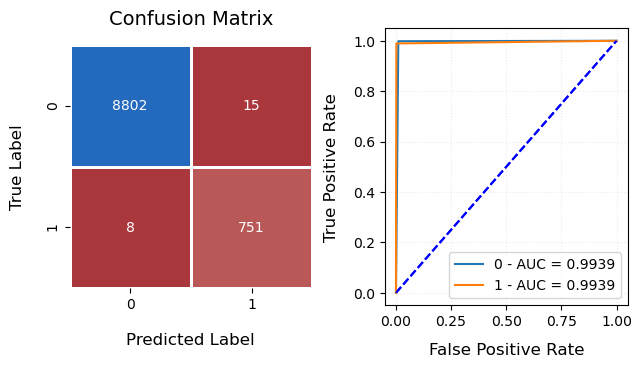

In [44]:
clf.fit(x_train_reduced_info_gain, y_train_undersampled);
y_pred = clf.predict(x_test_reduced_info_gain)

metrics_list.append(metrics(y_test, y_pred))

### 3. ANOVA f-test

Test Accuracy: 99.7598%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8817
           1       0.98      0.99      0.98       759

    accuracy                           1.00      9576
   macro avg       0.99      0.99      0.99      9576
weighted avg       1.00      1.00      1.00      9576



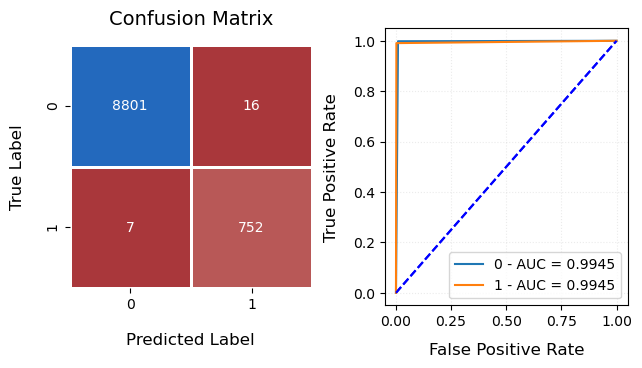

In [45]:
clf.fit(x_train_reduced_anova, y_train_undersampled);
y_pred = clf.predict(x_test_reduced_anova)

metrics_list.append(metrics(y_test, y_pred))

### 4. Forward Feature Selection

Test Accuracy: 99.7598%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8817
           1       0.98      0.99      0.98       759

    accuracy                           1.00      9576
   macro avg       0.99      0.99      0.99      9576
weighted avg       1.00      1.00      1.00      9576



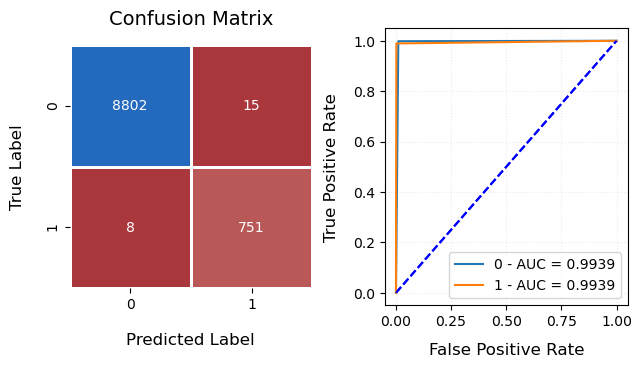

In [46]:
clf.fit(x_train_reduced_ffs, y_train_undersampled);
y_pred = clf.predict(x_test_reduced_ffs)

metrics_list.append(metrics(y_test, y_pred))

### 5. Lasso Regression

Test Accuracy: 99.7494%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8817
           1       0.98      0.99      0.98       759

    accuracy                           1.00      9576
   macro avg       0.99      0.99      0.99      9576
weighted avg       1.00      1.00      1.00      9576



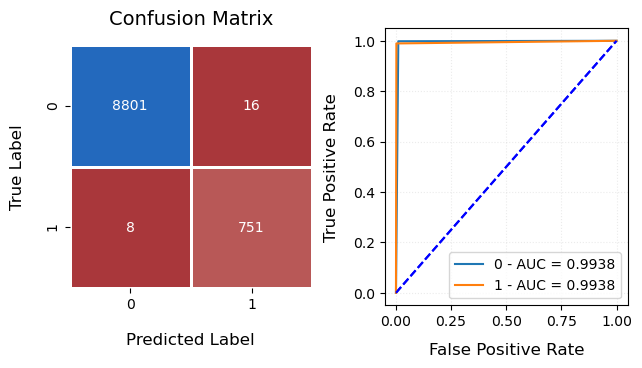

In [47]:
clf.fit(x_train_reduced_lasso, y_train_undersampled);
y_pred = clf.predict(x_test_reduced_lasso)

metrics_list.append(metrics(y_test, y_pred))

## Support Vector Machine

In [48]:
clf = SVC()

### 1. Extra Trees

Test Accuracy: 98.3396%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      8817
           1       0.84      0.98      0.90       759

    accuracy                           0.98      9576
   macro avg       0.92      0.98      0.95      9576
weighted avg       0.99      0.98      0.98      9576



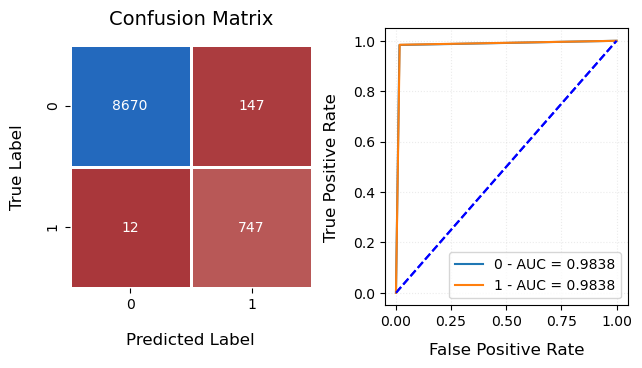

In [49]:
clf.fit(x_train_reduced_extra_trees, y_train_undersampled);
y_pred = clf.predict(x_test_reduced_extra_trees)

metrics_list.append(metrics(y_test, y_pred))

### 2. Mutual Info Gain

Test Accuracy: 97.2222%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98      8817
           1       0.76      0.95      0.84       759

    accuracy                           0.97      9576
   macro avg       0.88      0.96      0.91      9576
weighted avg       0.98      0.97      0.97      9576



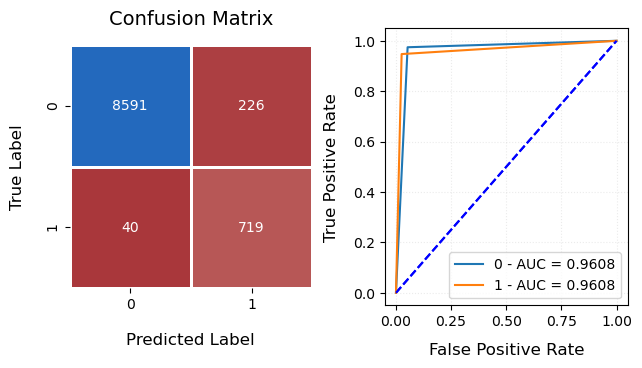

In [50]:
clf.fit(x_train_reduced_info_gain, y_train_undersampled);
y_pred = clf.predict(x_test_reduced_info_gain)

metrics_list.append(metrics(y_test, y_pred))

### 3. ANOVA f-test

Test Accuracy: 98.3396%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      8817
           1       0.84      0.98      0.90       759

    accuracy                           0.98      9576
   macro avg       0.92      0.98      0.95      9576
weighted avg       0.99      0.98      0.98      9576



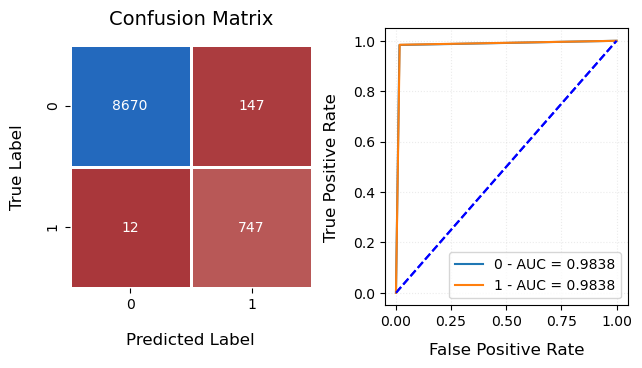

In [51]:
clf.fit(x_train_reduced_anova, y_train_undersampled);
y_pred = clf.predict(x_test_reduced_anova)

metrics_list.append(metrics(y_test, y_pred))

### 4. Forward Feature Selection

Test Accuracy: 96.6479%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98      8817
           1       0.72      0.95      0.82       759

    accuracy                           0.97      9576
   macro avg       0.86      0.96      0.90      9576
weighted avg       0.97      0.97      0.97      9576



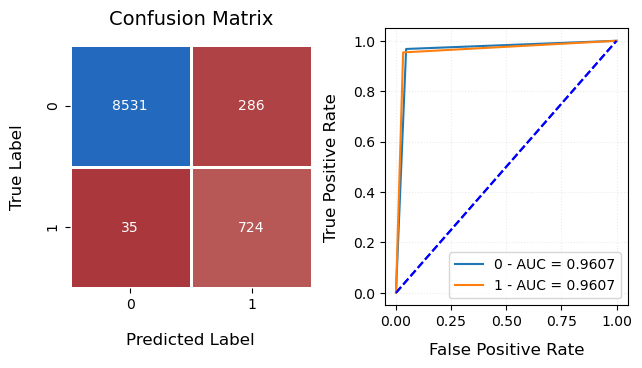

In [52]:
clf.fit(x_train_reduced_ffs, y_train_undersampled);
y_pred = clf.predict(x_test_reduced_ffs)

metrics_list.append(metrics(y_test, y_pred))

### 5. Lasso Regression

Test Accuracy: 96.1257%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      8817
           1       0.69      0.92      0.79       759

    accuracy                           0.96      9576
   macro avg       0.84      0.94      0.88      9576
weighted avg       0.97      0.96      0.96      9576



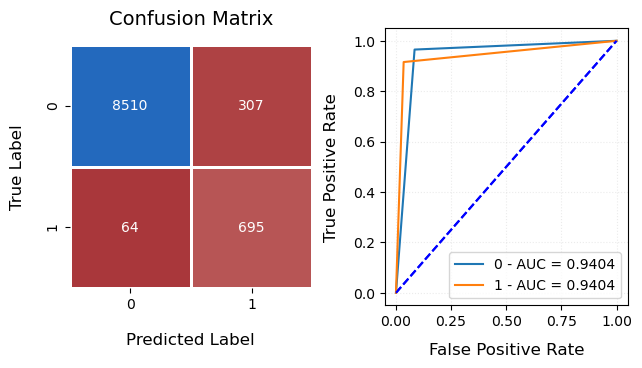

In [53]:
clf.fit(x_train_reduced_lasso, y_train_undersampled);
y_pred = clf.predict(x_test_reduced_lasso)

metrics_list.append(metrics(y_test, y_pred))

# Validation Metrics

In [54]:
classifier_names = ["Naive Bayes", "Logistic Regression", "KNN", "Random Forest", "SVM"]
feature_sel = ["Extra Trees", "Mutual Info Gain", "ANOVA f-test", "Forward Feat Sel", "Lasso Regression"]

In [55]:
metrics_list = np.array(metrics_list)

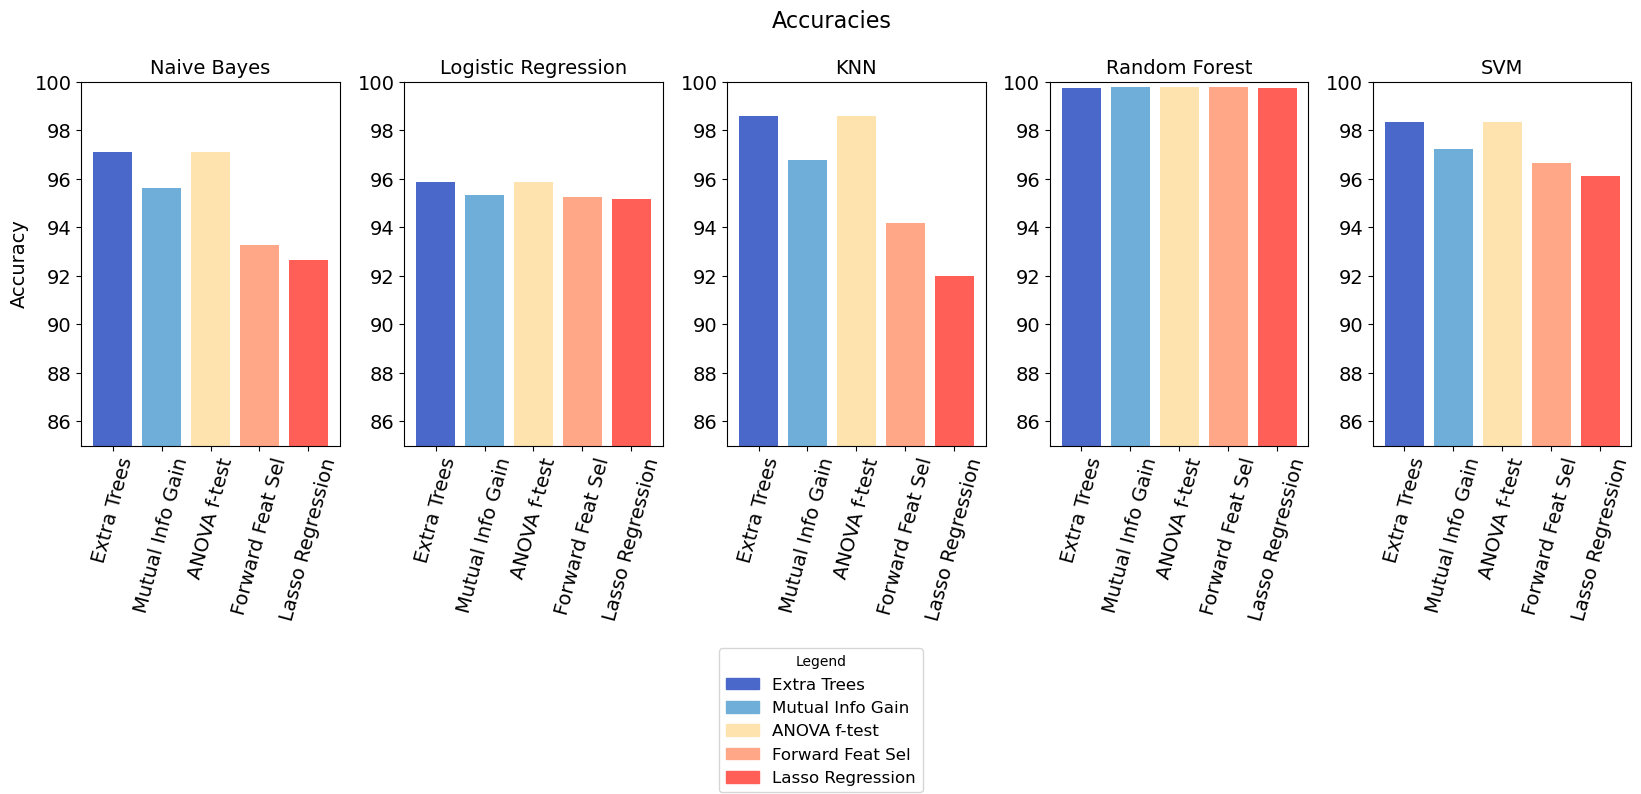

In [56]:
fig, ax = plt.subplots(1, 5, figsize=(20, 8), dpi=100)
cols = ['#4a68ca', '#6eaed9', '#ffe3af', '#ffa787', '#ff5f57']
ac = np.array(metrics_list[:,0].reshape(-1,5))

for i in range(5):
    ax[i].bar(x = range(5), height = ac[i], color=cols)
    ax[i].set_ylim(85, 100)
    ax[i].set_title(classifier_names[i], fontsize=14)
    ax[i].set_xticks(ticks=range(5), labels=feature_sel, rotation=75, fontsize=14)
    ax[i].set_yticks(ticks=np.arange(86,102,step=2), 
                     labels=np.round(np.arange(86,102,step=2), decimals=2), 
                     fontsize=14)
ax[0].set_ylabel("Accuracy", fontsize=14)

patches = []
for i in range(5):
    patches.append(mpatches.Patch(color=cols[i], label=feature_sel[i]))
fig.legend(handles=patches,
           loc="lower center",
           borderaxespad=0.1,
           title="Legend", fontsize=12);

plt.subplots_adjust(bottom=0.425);
plt.suptitle("Accuracies", y=.97, fontsize=16);
plt.subplots_adjust(wspace=0.25);

In [57]:
idx = pd.MultiIndex.from_product([classifier_names, feature_sel])
metrics_df = pd.DataFrame(metrics_list, 
                          index=idx, 
                          columns=['accuracy', 'recall', 'precision', 'f1_score', 'mcc', 'auc_score'])
metrics_df 

accuracy    recall  precision  \
Naive Bayes         Extra Trees       97.107352  0.918314   0.764254   
                    Mutual Info Gain  95.634921  0.916996   0.662226   
                    ANOVA f-test      97.107352  0.918314   0.764254   
                    Forward Feat Sel  93.285297  0.910408   0.545814   
                    Lasso Regression  92.637845  0.864295   0.521463   
Logistic Regression Extra Trees       95.864662  0.894598   0.682412   
                    Mutual Info Gain  95.332080  0.889328   0.650289   
                    ANOVA f-test      95.864662  0.894598   0.682412   
                    Forward Feat Sel  95.258981  0.897233   0.644276   
                    Lasso Regression  95.154553  0.889328   0.639810   
KNN                 Extra Trees       98.600668  0.990777   0.855518   
                    Mutual Info Gain  96.752297  0.945982   0.726721   
                    ANOVA f-test      98.600668  0.990777   0.855518   
                    Forward Feat Sel  94.193818  0.911726   0.585944   
                    Lasso Regression  91.979950  0.828722   0.496448   
Random Forest       Extra Trees       99.749373  0.990777   0.977893   
                    Mutual Info Gain  99.759816  0.989460   0.980418   
                    ANOVA f-test      99.759816  0.990777   0.979167   
                    Forward Feat Sel  99.759816  0.989460   0.980418   
                    Lasso Regression  99.749373  0.989460   0.979140   
SVM                 Extra Trees       98.339599  0.984190   0.835570   
                    Mutual Info Gain  97.222222  0.947299   0.760847   
                    ANOVA f-test      98.339599  0.984190   0.835570   
                    Forward Feat Sel  96.647870  0.953887   0.716832   
                    Lasso Regression  96.125731  0.915679   0.693613   

                                      f1_score       mcc  auc_score  
Naive Bayes         Extra Trees       0.834231  0.822674   0.946964  
                    Mutual Info Gain  0.769061  0.757705   0.938366  
                    ANOVA f-test      0.834231  0.822674   0.946964  
                    Forward Feat Sel  0.682469  0.674093   0.922597  
                    Lasso Regression  0.650471  0.636582   0.898009  
Logistic Regression Extra Trees       0.774230  0.760277   0.929379  
                    Mutual Info Gain  0.751252  0.737023   0.924079  
                    ANOVA f-test      0.774230  0.760277   0.929379  
                    Forward Feat Sel  0.750000  0.736727   0.927294  
                    Lasso Regression  0.744212  0.730126   0.923115  
KNN                 Extra Trees       0.918193  0.913520   0.988187  
                    Mutual Info Gain  0.821981  0.812921   0.957679  
                    ANOVA f-test      0.918193  0.913520   0.988187  
                    Forward Feat Sel  0.713402  0.703484   0.928132  
                    Lasso Regression  0.620928  0.603043   0.878181  
Random Forest       Extra Trees       0.984293  0.982956   0.994425  
                    Mutual Info Gain  0.984918  0.983625   0.993879  
                    ANOVA f-test      0.984938  0.983653   0.994481  
                    Forward Feat Sel  0.984918  0.983625   0.993879  
                    Lasso Regression  0.984273  0.982927   0.993823  
SVM                 Extra Trees       0.903811  0.898383   0.983759  
                    Mutual Info Gain  0.843897  0.834851   0.960833  
                    ANOVA f-test      0.903811  0.898383   0.983759  
                    Forward Feat Sel  0.818542  0.810407   0.960725  
                    Lasso Regression  0.789324  0.777432   0.940430

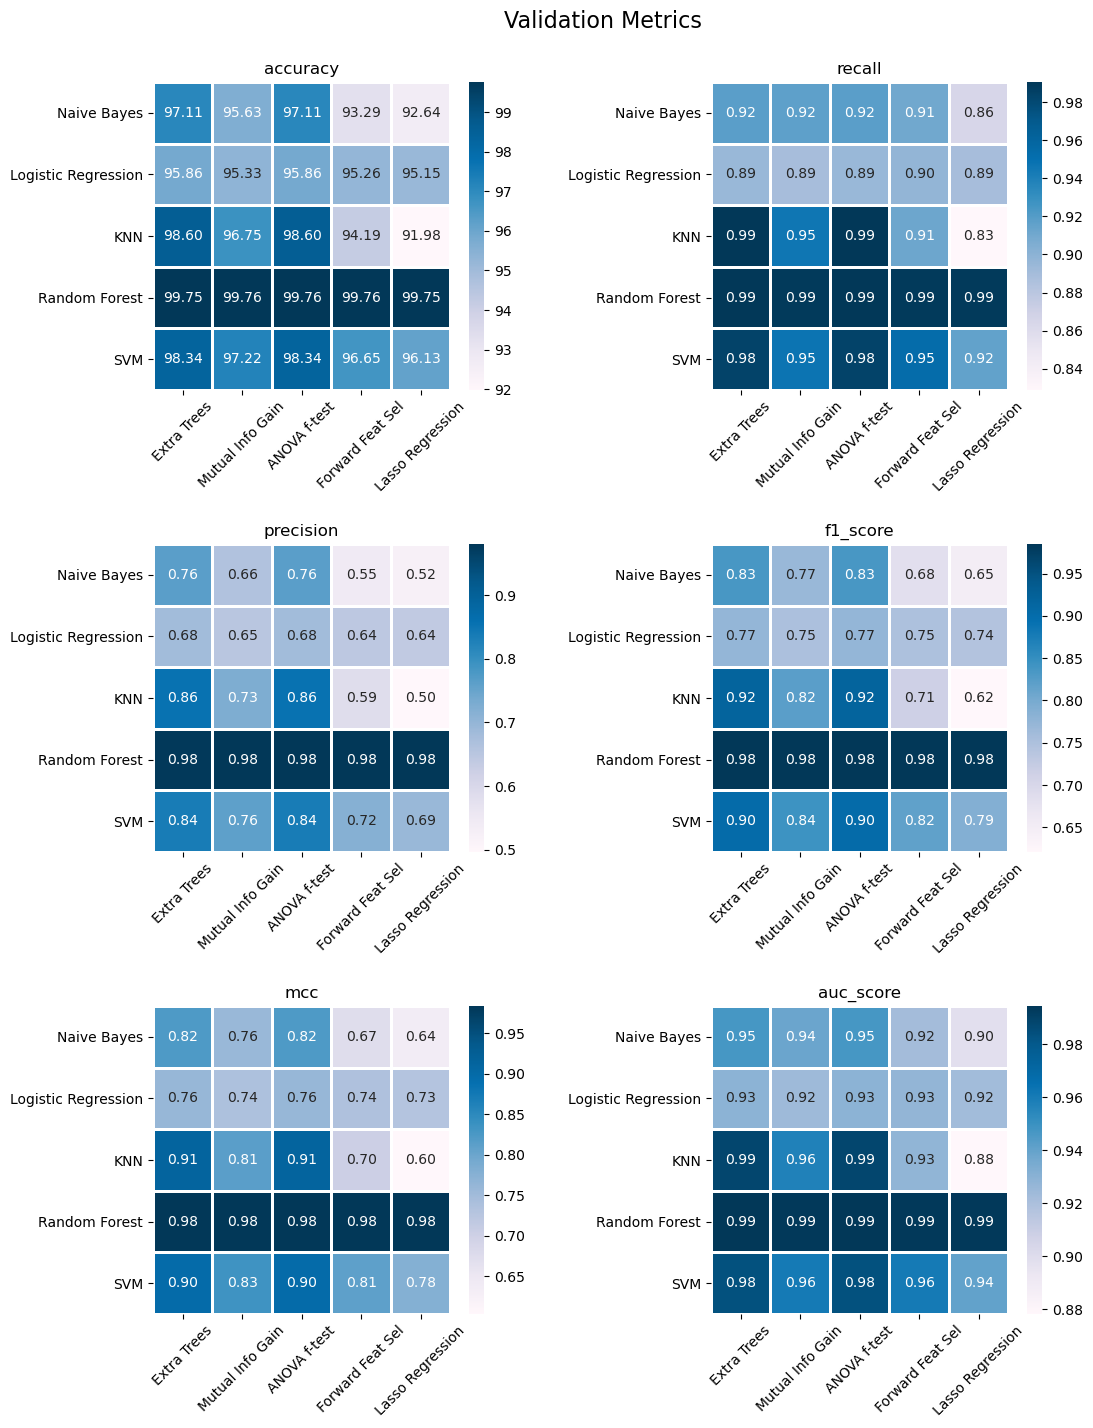

In [58]:
fig, ax = plt.subplots(3, 2, figsize=(12, 16))

for i in range(len(ax.ravel())):
    
    sns.heatmap(metrics_df[metrics_df.columns.tolist()[i]].values.reshape(-1,5), 
                cmap='PuBu', 
                linecolor='white', 
                linewidth=1, 
                annot=True, ax=ax.ravel()[i], 
                fmt='.2f');
    
    ax.ravel()[i].set_title(metrics_df.columns.tolist()[i])
    ax.ravel()[i].set_yticklabels(classifier_names, rotation=0)
    ax.ravel()[i].set_xticklabels(feature_sel, rotation=45)
    
    plt.subplots_adjust(wspace=0.5, hspace=0.5);
    plt.suptitle("Validation Metrics", y=0.925, fontsize=16)